# Projet 5 : Segmentez les comportements de clients
# <u>C. Modèle de classification automatique des clients</u> <br/>

# Le contexte

Notre employeur Datazon souhaite mieux comprendre le comportements de ses clients afin de faire de meilleures ventes et augmenter son chiffre d'affaire.

Notre **objectif** est de mieux comprendre les clients afin de les classer en catégories et de déterminer automatiquement la catégorie d'un client dès son premier achat.

Ce notebook traite de la partie classification automatique des clients pour trouver leur type de catégorie. Pour celà nous allons tester et évaluer différents modéles de classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import  manifold, cluster
from IPython.display import display

from sklearn import model_selection, metrics
from sklearn.svm import SVC
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix,roc_curve, auc
import itertools
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize


%matplotlib inline

# 1. Importation des données

In [2]:
customers_data= pd.read_csv('customers_data.csv')

In [3]:
customers_data.head()

,CustomerID,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase,Cluster
0,12346.0,2,0.00,0.00,-77183.60,77183.60,0,1,0,0,1,325,3
1,12347.0,3,1082.73,360.91,224.82,475.39,703,0,0,0,0,2,4
2,12348.0,3,1249.80,416.60,270.00,652.80,1732,0,0,0,0,75,4
3,12349.0,1,1457.55,1457.55,1457.55,1457.55,630,0,0,0,0,18,4
4,12350.0,1,294.40,294.40,294.40,294.40,196,0,0,0,0,310,0


# 2. Tests des modèles de classification

## 2.1 Préparation des données

Notre target variable et le numéro de cluster qui donnera la catégorie du client.
On utilise les autres features pour notre apprentissage.

In [3]:
Y = customers_data['Cluster']
X = customers_data.drop(['CustomerID','Cluster'], axis=1)

In [4]:
X.head()

,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase
0,2,0.00,0.00,-77183.60,77183.60,0,1,0,0,1,325
1,3,1082.73,360.91,224.82,475.39,703,0,0,0,0,2
2,3,1249.80,416.60,270.00,652.80,1732,0,0,0,0,75
3,1,1457.55,1457.55,1457.55,1457.55,630,0,0,0,0,18
4,1,294.40,294.40,294.40,294.40,196,0,0,0,0,310


On découpe les données en jeu d'entrainement et de test pour notre apprentissage (70% / 30%)

In [5]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,Y,test_size = 0.3,random_state = 0)

On standardise nos données pour les centrer / normer avant de tester nos modèles.

In [6]:
# On attribue un score en fonction de quantile d'appartenance de la donnée
def getScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

# Calcul score pour les données dont la valorisation est plus importance si la valeur est faible
# Ex : LastPurchase. Plus la valeur est petite, plus l'achat est récent donc à une valorisation importante pour nous.
def getRScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Transforme les données en score de quantile et retourne une matrice
def createQuantileMatrix(X) :
    quantiles = X.quantile(q=[0.25,0.5,0.75])
    quantiles = quantiles.to_dict()
    X_std=X.copy()
    for column in X:
        if (column == 'LastPurchase') :
            X_std[column] = X[column].apply(getRScore, args=(column,quantiles,))
        else :
            X_std[column] = X[column].apply(getScore, args=(column,quantiles,))
    return X_std

In [7]:
x_train = createQuantileMatrix(x_train)
x_test = createQuantileMatrix(x_test)

## 2.2 Evaluation des modèles

Méthodes génériques qui seront utilisées pour l'évaluation de nos modèles de classification.

In [8]:
'''
Méthode générique pour faire une recherche sur grille et évaluer le modèle de classification.
Affiche les meilleurs paramètres et la précision du modèle.
'''
def evaluateClassifier(classifier, parameters, x_train, y_train, x_test, y_test) :
    Kfold = 5
    gs_classifier = GridSearchCV(estimator = classifier, param_grid = parameters, cv = Kfold)
    fit = gs_classifier.fit(x_train, y_train)
    print("Best params :", gs_classifier.best_params_)
    y_pred = gs_classifier.predict(x_test)
    
    print("Classification accuracy: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred)))
    return gs_classifier, y_pred

In [11]:
'''
Affichage de la matrice de confusion
'''
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def displayConfusionMatrix(y_test, y_pred,n_classes) :
    class_names = [i for i in range(n_classes)]
    cnf_matrix = confusion_matrix(y_test, y_pred) 
    np.set_printoptions(precision=2)
    plt.figure(figsize = (5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

## 2.3 SVM Linéaire

On teste le modèle de machine à vecteurs de support.

In [9]:
svc = svm.LinearSVC()
parameters = [{'C':np.logspace(-3,3,10)}]
svc_grid, y_pred = evaluateClassifier(svc,parameters, x_train, y_train, x_test, y_test  )

Best params : {'C': 2.154434690031882}
Classification accuracy: 96.73 % 


Confusion matrix, without normalization


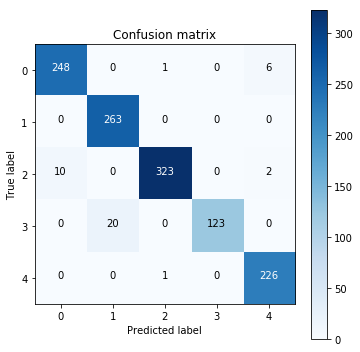

In [12]:
displayConfusionMatrix(y_test, y_pred,5)

## 2.4 Logistic Regression

In [13]:
lr = linear_model.LogisticRegression()
parameters = [{'penalty': ['l2', 'l1'],'C':np.logspace(-2,2,20)}]
lr_grid, y_pred = evaluateClassifier(lr,parameters, x_train, y_train, x_test, y_test )

Best params : {'C': 61.584821106602604, 'penalty': 'l2'}
Classification accuracy: 96.65 % 


Confusion matrix, without normalization


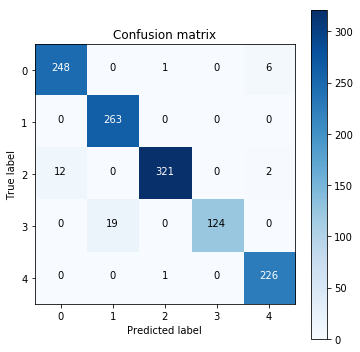

In [14]:
displayConfusionMatrix(y_test, y_pred,5)

## 2.5 Decision Tree

In [15]:
dt = tree.DecisionTreeClassifier()
parameters = [{'criterion' : ['entropy', 'gini'], 'max_depth': [1, 2, 3, 4, 5],'max_features': [1,2,3]}]
dt_grid, y_pred = evaluateClassifier(dt,parameters, x_train, y_train, x_test, y_test)

Best params : {'criterion': 'gini', 'max_depth': 4, 'max_features': 3}
Classification accuracy: 91.82 % 


Confusion matrix, without normalization


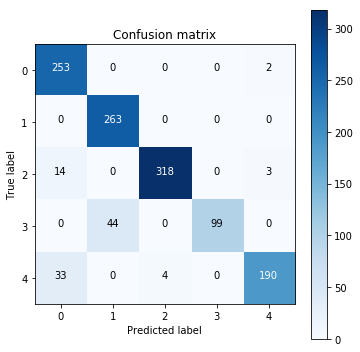

In [16]:
displayConfusionMatrix(y_test, y_pred,5)

## 2.6 KNN

In [16]:
knn = neighbors.KNeighborsClassifier()
parameters = [{'n_neighbors': np.arange(1,50,1), 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}]
knn_grid, y_pred = evaluateClassifier(knn,parameters, x_train, y_train, x_test, y_test  )

Best params : {'algorithm': 'auto', 'n_neighbors': 5}
Classification accuracy: 97.79 % 


Confusion matrix, without normalization


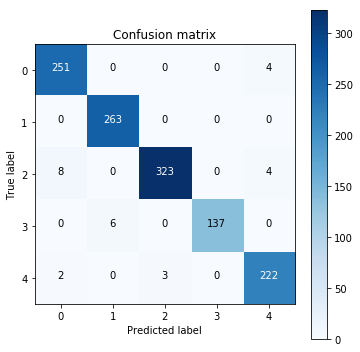

In [17]:
displayConfusionMatrix(y_test, y_pred,5)

## 2.7 Random Forest

In [18]:
rfc = RandomForestClassifier(oob_score = True)
parameters = { 
    'n_estimators': [50, 100, 200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
rfc_grid, y_pred = evaluateClassifier(rfc,parameters, x_train, y_train, x_test, y_test  )

Best params : {'max_features': 'auto', 'n_estimators': 200}
Classification accuracy: 97.63 % 


Confusion matrix, without normalization


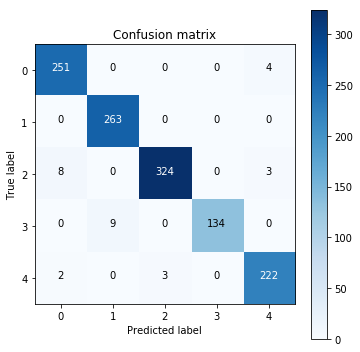

In [19]:
displayConfusionMatrix(y_test, y_pred,5)

## 2.8 XGBoost

In [20]:
xgb_model = xgb.XGBClassifier()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}
xgb_grid, y_pred = evaluateClassifier(xgb_model,parameters, x_train, y_train, x_test, y_test  )

Best params : {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1337, 'silent': 1, 'subsample': 0.8}
Classification accuracy: 95.34 % 


Confusion matrix, without normalization


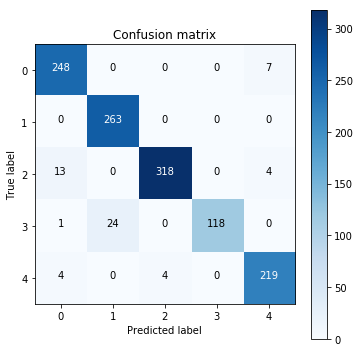

In [21]:
displayConfusionMatrix(y_test, y_pred,5)

## 2.9 Gradient Boosting

In [22]:
gb = ensemble.GradientBoostingClassifier()
parameters = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb_grid, y_pred = evaluateClassifier(gb,parameters, x_train, y_train, x_test, y_test  )

Best params : {'n_estimators': 60}
Classification accuracy: 97.47 % 


Confusion matrix, without normalization


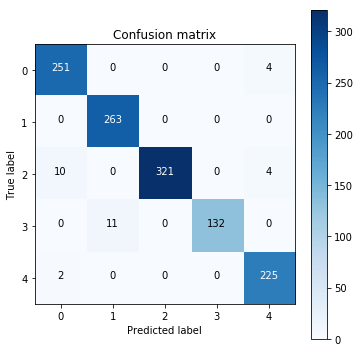

In [23]:
displayConfusionMatrix(y_test, y_pred,5)

## 2.10 Agregation des modèles

In [24]:
svc_best  = svm.LinearSVC(**svc_grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr_grid.best_params_)
dt_best  = tree.DecisionTreeClassifier(**dt_grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn_grid.best_params_)
rf_best  = RandomForestClassifier(**rfc_grid.best_params_)
xgb_best = xgb.XGBClassifier(**xgb_grid.best_params_)
gb_best = ensemble.GradientBoostingClassifier(**gb_grid.best_params_)

In [25]:
votingC = ensemble.VotingClassifier(estimators=[('lr',lr_best),('dt',dt_best),('gb', gb_best),('knn', knn_best)], voting='soft') 

In [26]:
votingC = votingC.fit(x_train,y_train)

In [27]:
y_pred = votingC.predict(x_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred)))

Precision: 96.89 % 
